## Data exploration

Now that we've cleaned our data, we can start exploring it

In [1]:
!pip install fastai2
!pip install kornia

     |████████████████████████████████| 184 kB 1.4 MB/s 
     |████████████████████████████████| 142 kB 1.4 MB/s 
     |████████████████████████████████| 2.1 MB 27.9 MB/s 
ERROR: catalyst 20.3.3 has requirement Pillow<7, but you'll have pillow 7.1.1 which is incompatible.
  Attempting uninstall: pillow
    Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [2]:
import seaborn as sns
from fastai2.vision.all import *
from fastai2.medical.imaging import *

In [3]:
trn_path = Path('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/')
csv_path = Path('../input/all-csvs')

Number of image files we have

In [4]:
fn = get_image_files(trn_path)
len(fn)

194082

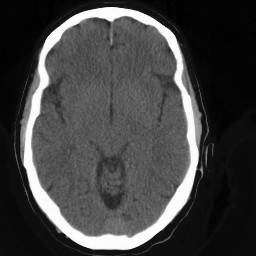

In [5]:
img = PILImage.create(fn[12], mode = 'L')
img

In [6]:
def read_image(x, mode = 'L'): return PILImage.create(x, mode = mode)
def read_images(imgs, **kwargs): return L([read_image(x, **kwargs) for x in imgs])

In [7]:
trn_imgs = read_images(fn[:200])
np.random.shuffle(trn_imgs)

In [8]:
def show_batch(x, nrows = 5, ncols = 5, title = None):
    """
    Read a list of images, and display them
    """
    fig=plt.figure(figsize=(9, 9))
    if title: plt.title(title)
    for i in range(1, ncols*nrows +1):
        ds = x[i]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(ds, cmap=plt.cm.bone)
        fig.add_subplot

Let's take a look at some of the images

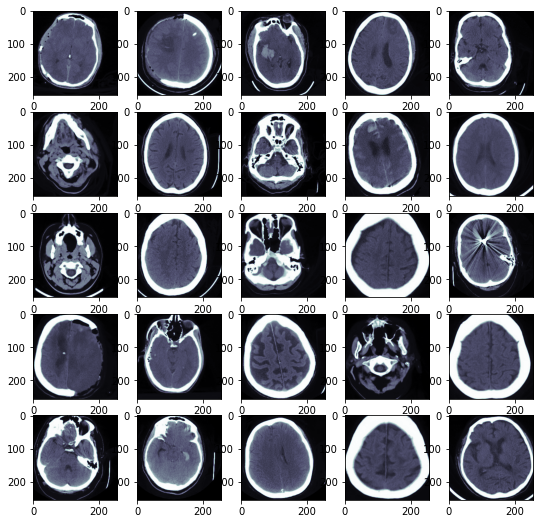

In [9]:
show_batch(trn_imgs)

We transpose and print the head to be able to see all the columns.

In [10]:
df = pd.read_csv(csv_path/'df_trn.csv')
df.head().T

,0,1,2,3,4
BitsAllocated,16,16,16,16,16
BitsStored,16,16,12,16,12
Columns,512,512,512,512,512
HighBit,15,15,11,15,11
ImageOrientationPatient,1,1,1,1,1
ImageOrientationPatient1,0,0,0,0,0
ImageOrientationPatient2,0,0,0,0,0
ImageOrientationPatient3,0,0,0,0,0
ImageOrientationPatient4,1,0.927184,1,0.945519,1
ImageOrientationPatient5,0,-0.374607,0,-0.325568,0


In [11]:
df.shape

(194082, 42)

Let's start by checking for null values

In [12]:
df.isnull().sum()

BitsAllocated                        0
BitsStored                           0
Columns                              0
HighBit                              0
ImageOrientationPatient              0
ImageOrientationPatient1             0
ImageOrientationPatient2             0
ImageOrientationPatient3             0
ImageOrientationPatient4             0
ImageOrientationPatient5             0
ImagePositionPatient                 0
ImagePositionPatient1                0
ImagePositionPatient2                0
Modality                             0
MultiImageOrientationPatient         0
MultiImagePositionPatient            0
MultiPixelSpacing                    0
MultiWindowCenter               103205
MultiWindowWidth                103205
PatientID                            0
PhotometricInterpretation            0
PixelRepresentation                  0
PixelSpacing                         0
PixelSpacing1                        0
RescaleIntercept                     0
RescaleSlope             

Most columns don't have any null values. We can drop the columns that have too many missing values. Let's look at the labels as well.

In [13]:
labels = pd.read_csv(csv_path/'labels.csv')
labels.head()

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00008ce3c.jpg,0,0,0,0,0,0
1,ID_0000aee4b.jpg,0,0,0,0,0,0
2,ID_0002003a8.jpg,0,0,0,0,0,0
3,ID_0002081b6.jpg,1,0,1,0,0,0
4,ID_00027cbb1.jpg,0,0,0,0,0,0


In [14]:
assert labels.shape[0] == df.shape[0]

In [15]:
labels.isnull().sum()

ID                  0
any                 0
epidural            0
intraparenchymal    0
intraventricular    0
subarachnoid        0
subdural            0
dtype: int64

The label any will always be 1 if one of the subtypes is 1. Hence we can plot only any to see if there is a bleed or not

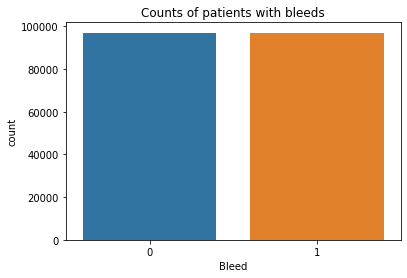

In [16]:
plt.title('Counts of patients with bleeds')
ax = sns.countplot(labels['any'])
ax.set(xlabel = 'Bleed')
plt.show()

Now let's see the counts of the individual types

In [17]:
cnts = labels[list(labels.columns)[2:]].sum()

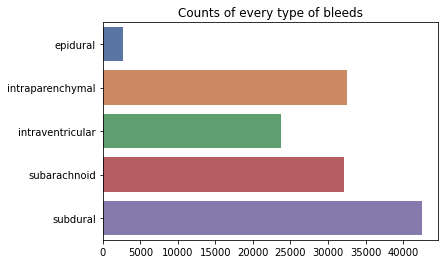

In [18]:
plt.title("Counts of every type of bleeds")
sns.barplot(y=cnts.index, x=cnts.values, palette="deep");

We see that subdural is the most common type of bleed. Let's see some subdural plots

In [19]:
fn[0].name

'ID_101ec1533.jpg'

In [20]:
subd = list(labels[labels['any'] == 1]['ID'])
subd[:3]

['ID_0002081b6.jpg', 'ID_0002a38ad.jpg', 'ID_000346ce2.jpg']

In [21]:
subd_names = [trn_path/x for x in subd]
subd_names[0]

Path('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/ID_0002081b6.jpg')

In [22]:
subd_imgs = read_images(subd_names[:30])

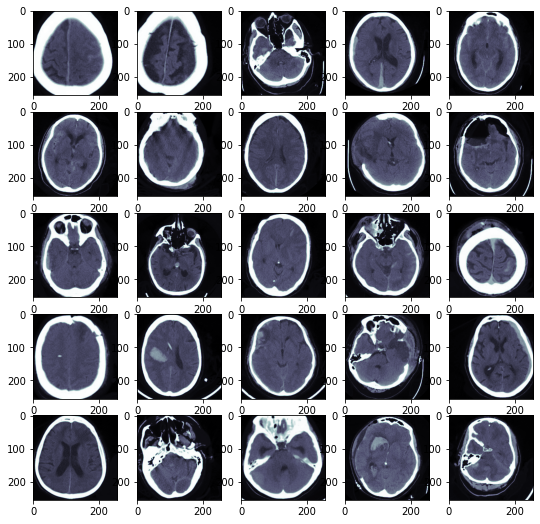

In [23]:
show_batch(subd_imgs)

If we look at the number of bits used to store the data, this may indicate that they came from 2 different organizations

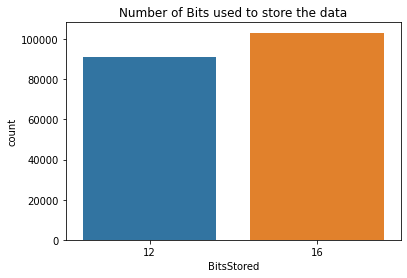

In [24]:
plt.title('Number of Bits used to store the data')
sns.countplot(df['BitsStored']);

Finally we can also see the images in various windows. However, this is only useful for human perception. Computers don't have perception and they don't need it. A neural network takes floating point input.

In [25]:
path = Path('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/')
path_trn = path/'stage_2_train'

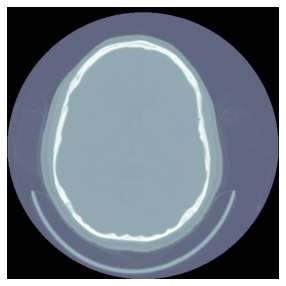

In [26]:
fname = path_trn/'ID_00019828f.dcm'
dcm = fname.dcmread()
dcm.show(scale=False)

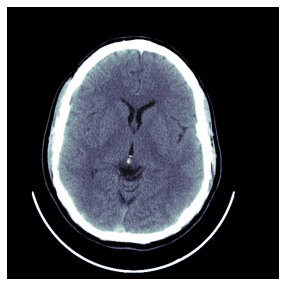

In [27]:
dcm.show(scale=dicom_windows.brain)

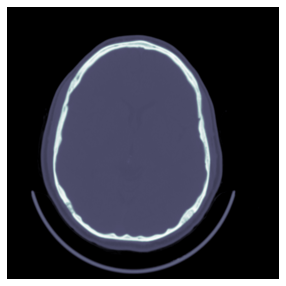

In [28]:
dcm.show(scale=dicom_windows.brain_bone)